In [25]:
import procgen

In [26]:
import procgen_tools

In [27]:
from procgen import ProcgenGym3Env


In [1]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns
import random

%load_ext autoreload
%autoreload 2

building procgen...done


In [2]:
ordered_layer_names = {
 0: 'conv_seqs',
 1: 'conv_seqs.0',
 2: 'conv_seqs.0.conv',
 3: 'conv_seqs.0.max_pool2d',
 4: 'conv_seqs.0.res_block0',
 5: 'conv_seqs.0.res_block0.conv0',
 6: 'conv_seqs.0.res_block0.conv1',
 7: 'conv_seqs.0.res_block1',
 8: 'conv_seqs.0.res_block1.conv0',
 9: 'conv_seqs.0.res_block1.conv1',
 10: 'conv_seqs.1',
 11: 'conv_seqs.1.conv',
 12: 'conv_seqs.1.max_pool2d',
 13: 'conv_seqs.1.res_block0',
 14: 'conv_seqs.1.res_block0.conv0',
 15: 'conv_seqs.1.res_block0.conv1',
 16: 'conv_seqs.1.res_block1',
 17: 'conv_seqs.1.res_block1.conv0',
 18: 'conv_seqs.1.res_block1.conv1',
 19: 'conv_seqs.2',
 20: 'conv_seqs.2.conv',
 21: 'conv_seqs.2.max_pool2d',
 22: 'conv_seqs.2.res_block0',
 23: 'conv_seqs.2.res_block0.conv0',
 24: 'conv_seqs.2.res_block0.conv1',
 25: 'conv_seqs.2.res_block1',
 26: 'conv_seqs.2.res_block1.conv0',
 27: 'conv_seqs.2.res_block1.conv1',
 28: 'hidden_fc',
 29: 'logits_fc',
 30: 'value_fc'
}


In [55]:
'''
    # Functions to read values of different types
    def read_fixed(sb, idx, fmt):
        sz = struct.calcsize(fmt)
        val = struct.unpack(fmt, sb[idx : (idx + sz)])[0]
        idx += sz
        return val, idx
'''

'\n    # Functions to read values of different types\n    def read_fixed(sb, idx, fmt):\n        sz = struct.calcsize(fmt)\n        val = struct.unpack(fmt, sb[idx : (idx + sz)])[0]\n        idx += sz\n        return val, idx\n'

In [3]:
def run_gem_steering_experiment(model_path, layer_number, modification_value, num_levels=1, start_level=5, episode_timeout=200, save_gif=False):
    start_level = random.randint(1, 10000)
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
    state = heist.state_from_venv(venv, 0)
    unchanged_obs = venv.reset()



    unchanged_obs= venv.reset()
    state_values = state.state_vals

    for ents in state_values["ents"]:
        if ents["image_type"].val== 9:
            gem_x = ents["x"].val 
            gem_y = ents["y"].val 

    state.remove_gem()


    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state = heist.state_from_venv(venv, 0)

    state.set_gem_position(gem_y-.5,gem_x-.5)

    state_bytes = state.state_bytes

    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
    # Load model and calculate steering vector
    model = helpers.load_model(model_path=model_path)
    layer_names = helpers.get_model_layer_names(model)
    steering_layer_unchanged = ordered_layer_names[layer_number]
    steering_layer = helpers.rename_path(steering_layer_unchanged)

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), layer_names)

    steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]


    # Run episode with steering
    total_reward_steering, frames_steering, observations_steering = helpers.run_episode_with_steering_and_save_as_gif(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_{episode}.gif',
        save_gif=save_gif, episode_timeout=episode_timeout
    )
    total_reward, frames, observations = helpers.run_episode_and_save_as_gif(
        venv, model, filepath=f'episode_{episode}.gif', save_gif=save_gif, episode_timeout=episode_timeout
    )
    return total_reward_steering,total_reward


model_path = "../model_final.pt"
modification_value = -2
total_episodes = 20
best_layer = None
best_score = 0

for layer_number in range(1, 30):  # Adjusted range to be between 1 and 29 inclusive
    count_rewards_0 = 0
    for episode in range(total_episodes):
        filepath=f'episode_steering_{episode}.gif'
        total_reward_steering, total_reward = run_gem_steering_experiment(model_path, layer_number, modification_value, save_gif=False)
        if total_reward_steering == 0:
            count_rewards_0 += 1
    print(f"Layer {ordered_layer_names[layer_number]}, {layer_number}: Number of times total reward steering was 0: {count_rewards_0}/{total_episodes}")
    if count_rewards_0 > best_score:
        best_score = count_rewards_0
        best_layer = layer_number

print(f"Best layer: {best_layer} with score: {best_score}")
    

Layer conv_seqs.0, 1: Number of times total reward steering was 0: 6/20


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1bbf6cc9d0>>
Traceback (most recent call last):
  File "/home/narmeen/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Layer conv_seqs.0.conv, 2: Number of times total reward steering was 0: 9/20


KeyboardInterrupt: 

In [4]:
def run_episode_with_steering_and_check_target_acquisition(env, model, steering_vector, steering_layer, modification_value,filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=True):
    observations = []
    observation = env.reset()

    done = False
    total_reward = 0
    frames=[]
    activations = {}
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_before = heist.get_lock_statuses(state_vals)
    print(lock_positions_before)
    num_changes_expected = len(lock_positions_before)
    num_changes_counted = 0
    count = 0
    while not done:
        
        if save_gif:
            frames.append(env.render(mode='rgb_array'))

        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action_with_steering(model, converted_obs, steering_vector, steering_layer,modification_value, is_procgen_env)

        observation, reward, done, info = env.step(action)

        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break
    
    if save_gif:
        imageio.mimsave(filepath, frames, fps=30)
        print(f"Saved gif to {filepath}")
    
    helpers.plot_single_observation(helpers.tensor_to_image(observation))
    

    if total_reward == 0: return True

    

    else: return False

[]


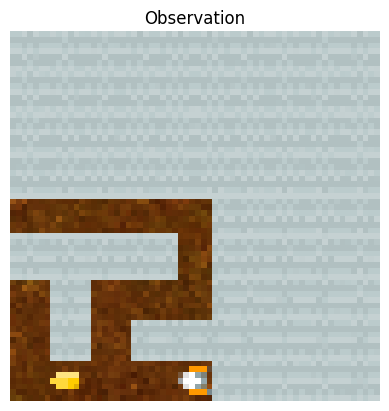

False

In [5]:
model_path = "../model_final.pt"
model = helpers.load_model(model_path=model_path)
layer_number = 14
start_level = 1000
save_gif = False
episode_timeout = 200
num_levels=1
venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)

start_level = random.randint(1, 10000)
venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
state = heist.state_from_venv(venv, 0)
unchanged_obs = venv.reset()



unchanged_obs= venv.reset()
state_values = state.state_vals

for ents in state_values["ents"]:
    if ents["image_type"].val== 9:
        gem_x = ents["x"].val 
        gem_y = ents["y"].val 

state.remove_gem()

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs = venv.reset()

state = heist.state_from_venv(venv, 0)

state.set_gem_position(gem_y-.5,gem_x-.5)

state_bytes = state.state_bytes

if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
# Load model and calculate steering vector
model = helpers.load_model(model_path=model_path)
layer_names = helpers.get_model_layer_names(model)
steering_layer_unchanged = ordered_layer_names[layer_number]
steering_layer = helpers.rename_path(steering_layer_unchanged)

model_activations = helpers.ModelActivations(model)
model_activations.clear_hooks()
output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
model_activations.clear_hooks()
output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), layer_names)

steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

run_episode_with_steering_and_check_target_acquisition(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_locks.gif',
        save_gif=False, episode_timeout=episode_timeout
    )


In [14]:
import numpy as np
import imageio
import helpers
import heist

def run_episode_with_steering_and_check_all_target_acquisition(env, model, steering_vector, steering_layer, modification_value, filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=True):
    observations = []
    observation = env.reset()

    done = False
    total_reward = 0
    frames = []
    activations = {}
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_before = heist.get_lock_statuses(state_vals)
    num_changes_expected = len(lock_positions_before)
    num_changes_counted = 0
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))

        observation = np.squeeze(observation)
        observation = np.transpose(observation, (1, 2, 0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action_with_steering(model, converted_obs, steering_vector, steering_layer, modification_value, is_procgen_env)

        observation, reward, done, info = env.step(action)
        if save_gif:
            helpers.plot_single_observation(helpers.tensor_to_image(observation))
        state_bytes = env.env.callmethod("get_state")[0]
        state = heist.EnvState(state_bytes)
        #state = heist.state_from_venv(env, 0)  # Get the updated state
        total_reward += reward
        observations.append(converted_obs)
        count += 1
        if count >= episode_timeout:
            break

    if save_gif:
        helpers.plot_single_observation(helpers.tensor_to_image(observation))

    def check_keys_and_locks(state):
        key_types = {0: "blue key", 1: "green key", 2: "red key"}
        lock_types = {0: "blue lock", 1: "green lock", 2: "red lock"}
    
        # Initialize empty lists to hold the names of present keys and locks
        present_keys = []
        present_locks = []
    
        # Iterate through the entities and update the lists based on presence
        for ents in state.state_vals["ents"]:
            if ents["image_type"].val == 2 and key_types[ents["image_theme"].val] not in present_keys:
                present_keys.append(key_types[ents["image_theme"].val])
            elif ents["image_type"].val == 1 and lock_types[ents["image_theme"].val] not in present_locks:
                present_locks.append(lock_types[ents["image_theme"].val])    
        return present_keys, present_locks
    
    # Usage example
    present_keys, present_locks = check_keys_and_locks(state)
    if not present_locks:
        present_keys = []

    return present_keys, present_locks,total_reward


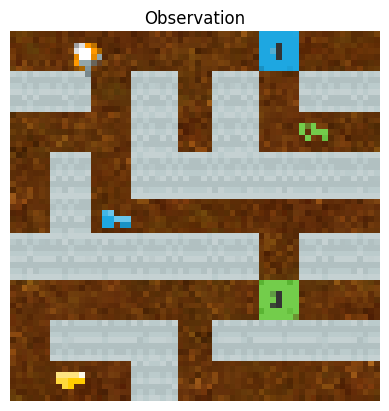

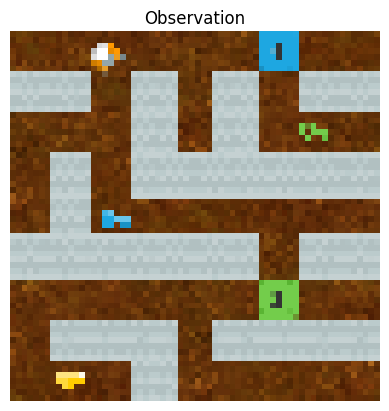

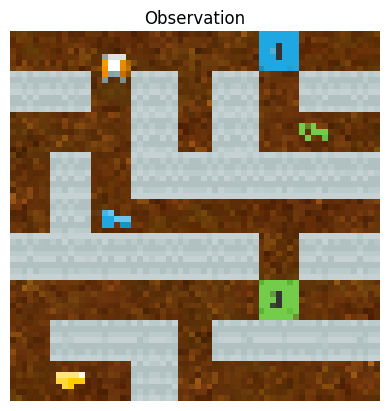

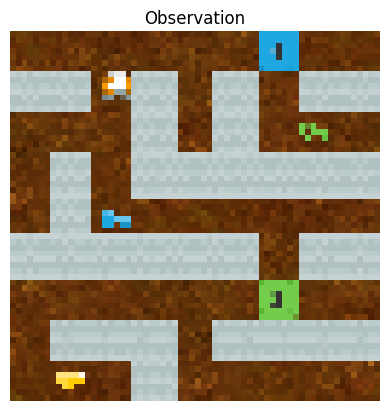

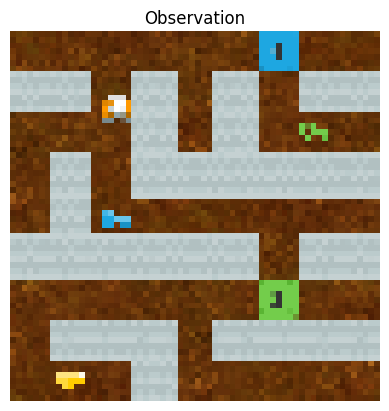

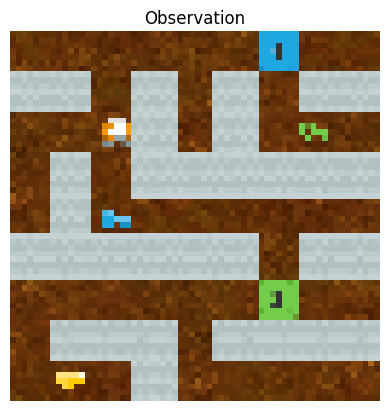

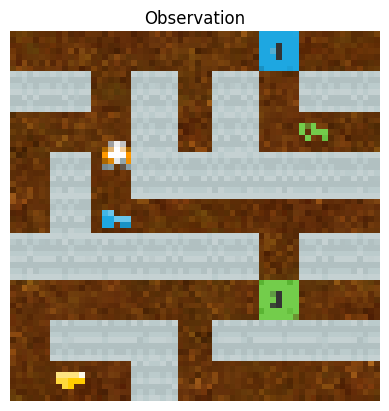

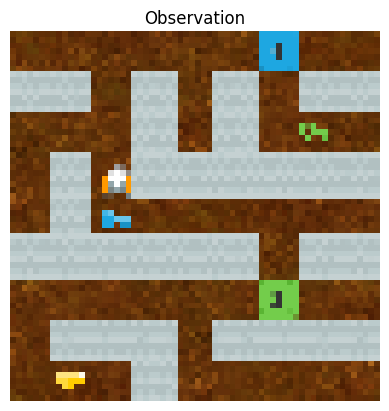

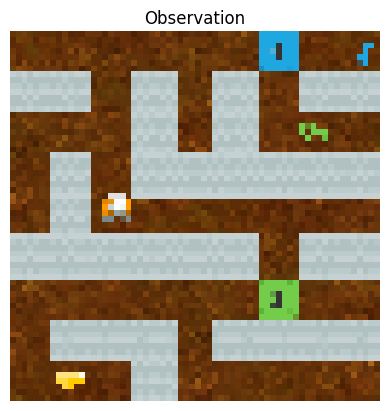

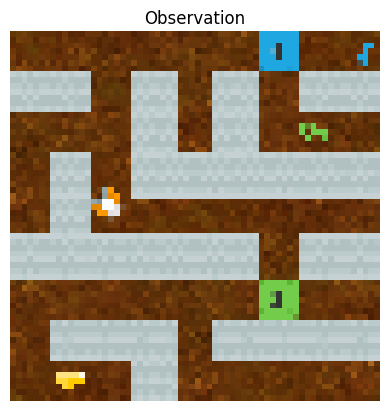

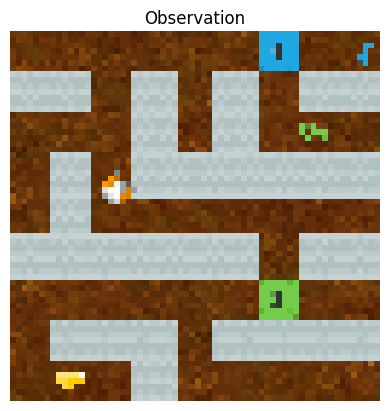

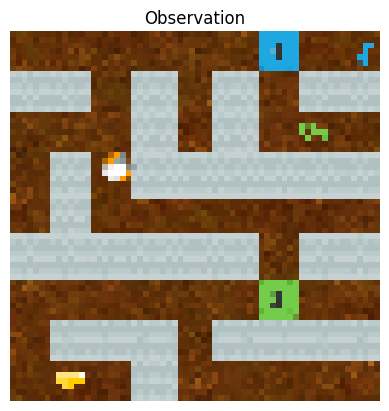

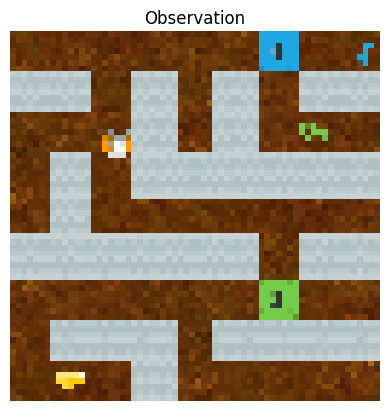

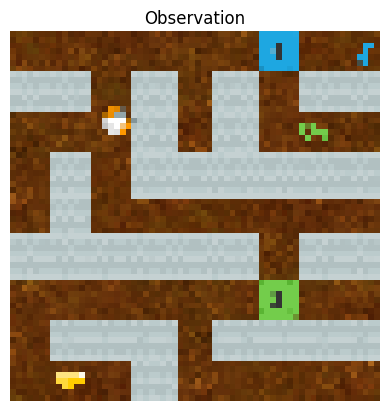

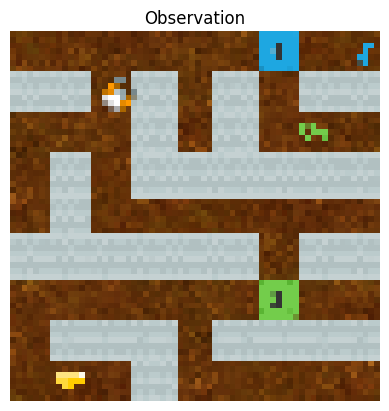

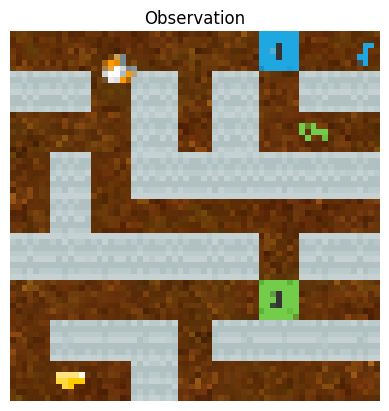

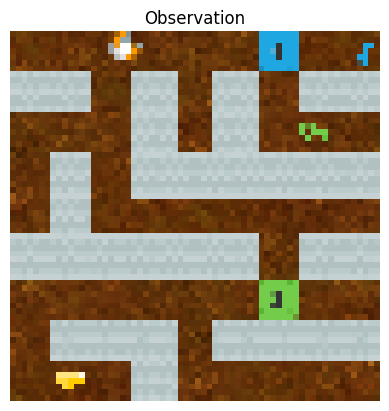

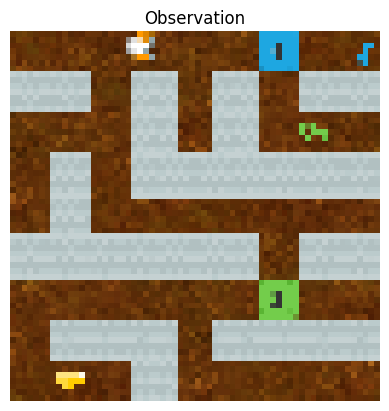

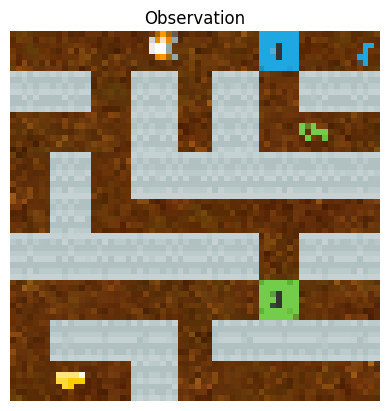

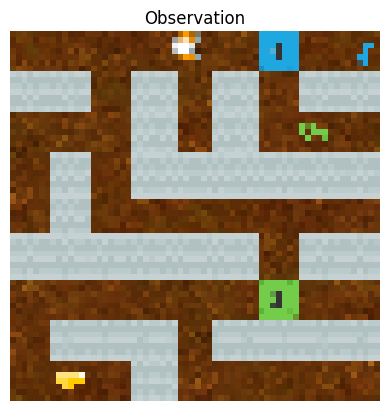

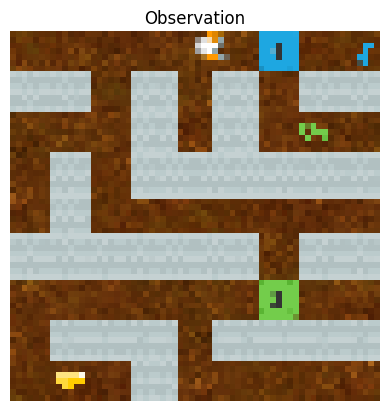

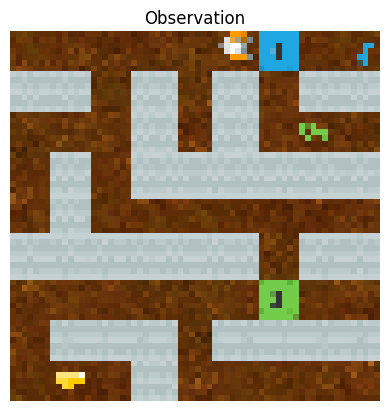

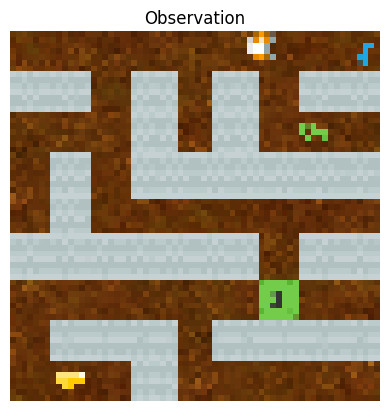

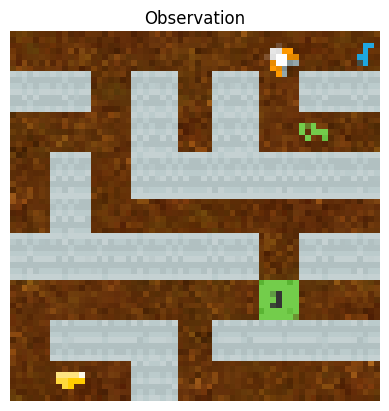

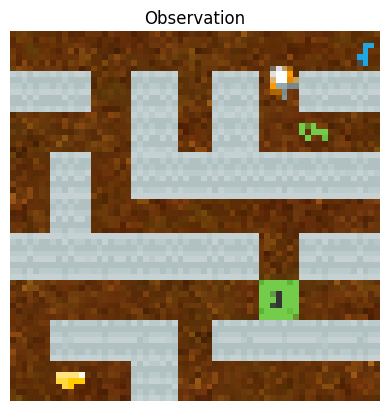

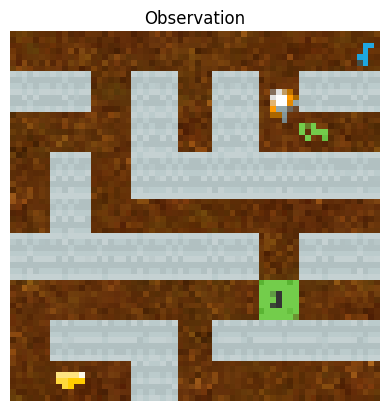

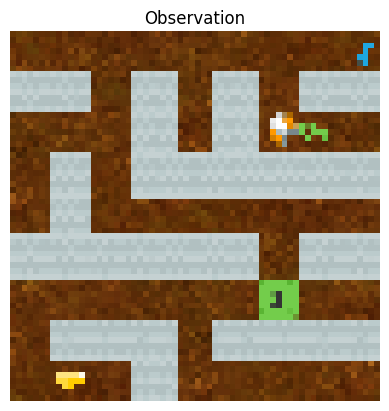

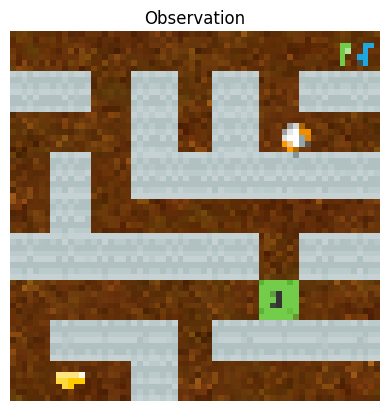

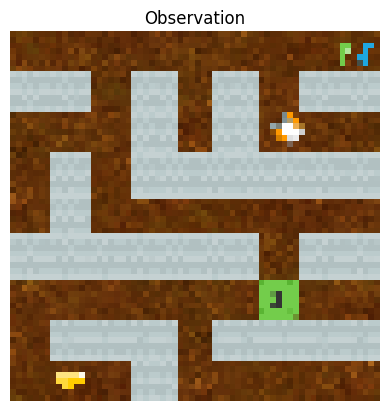

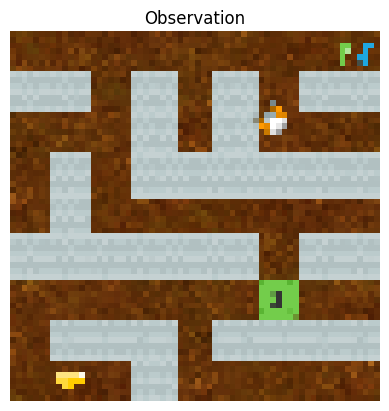

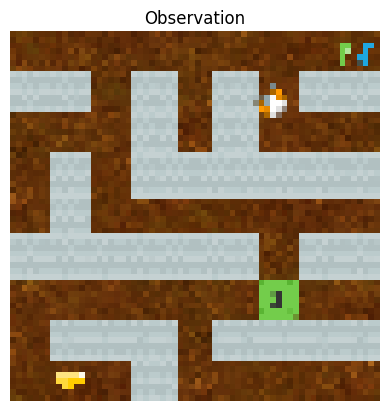

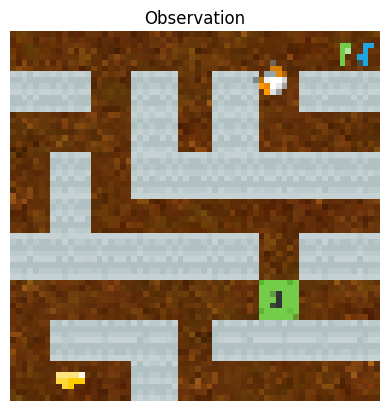

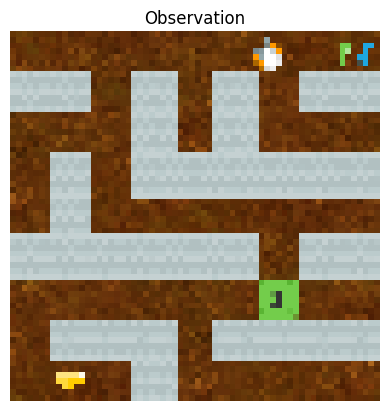

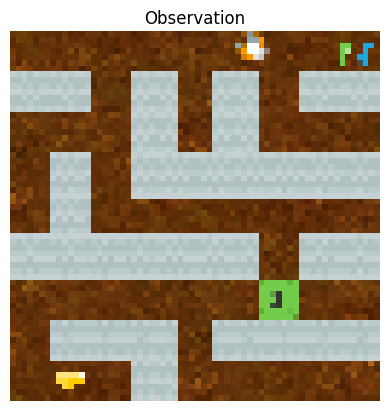

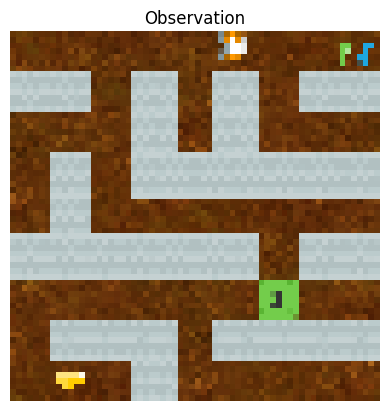

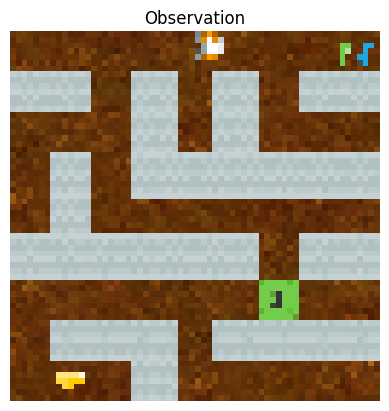

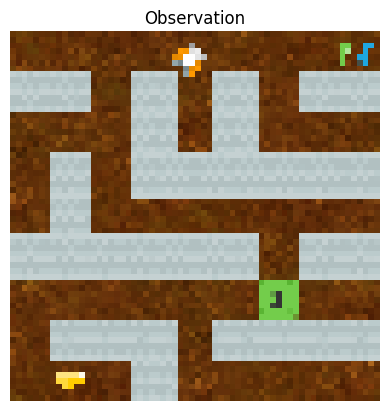

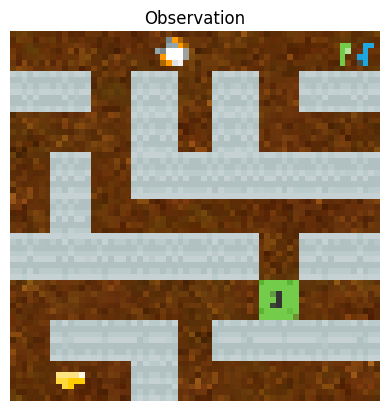

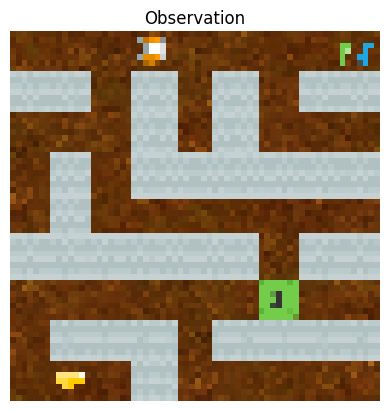

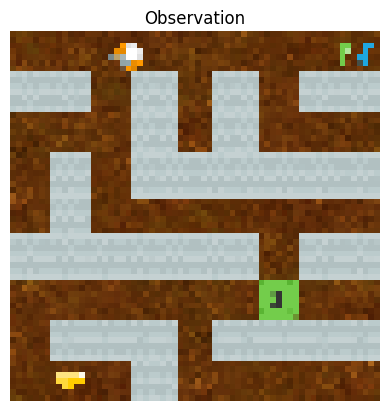

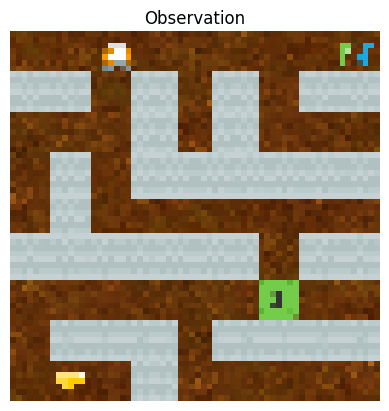

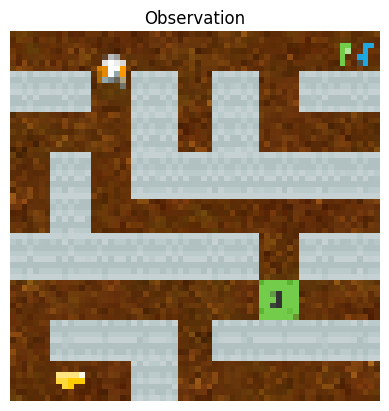

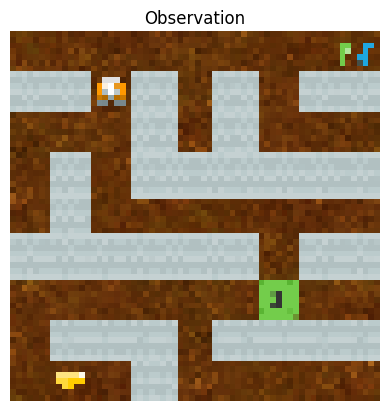

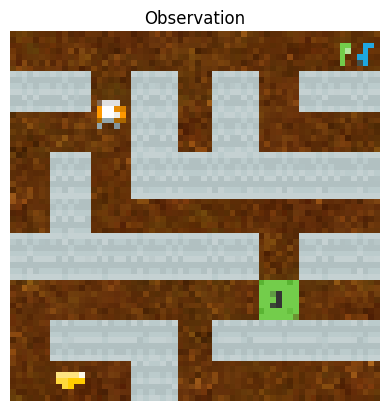

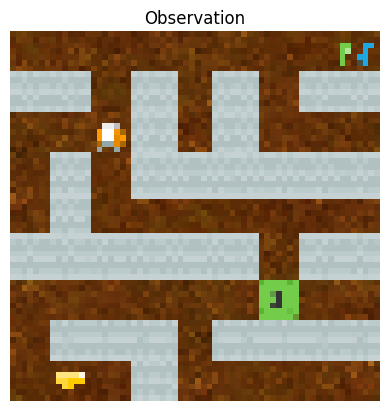

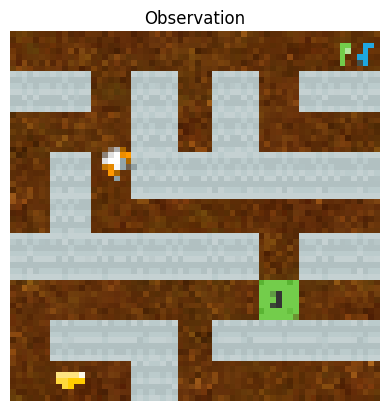

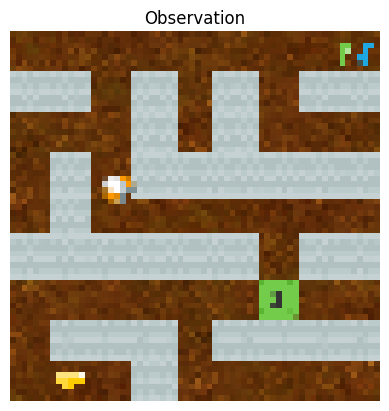

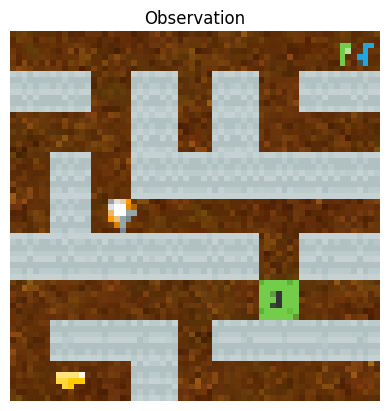

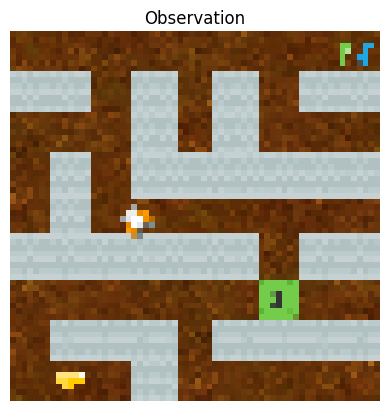

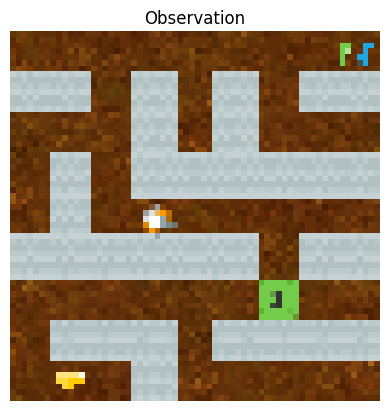

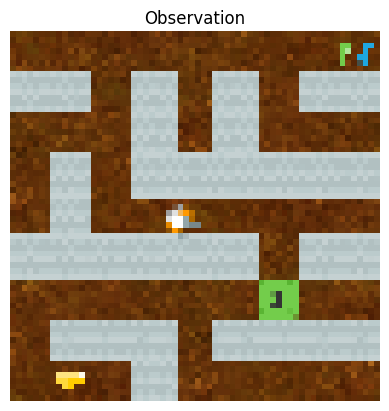

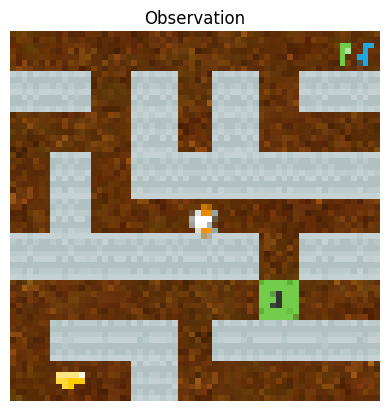

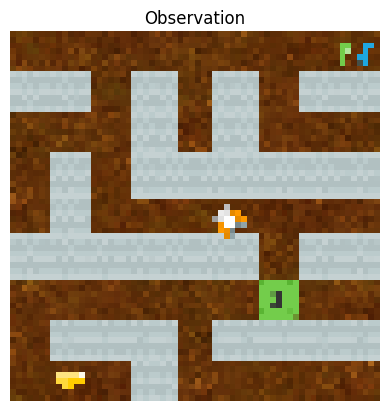

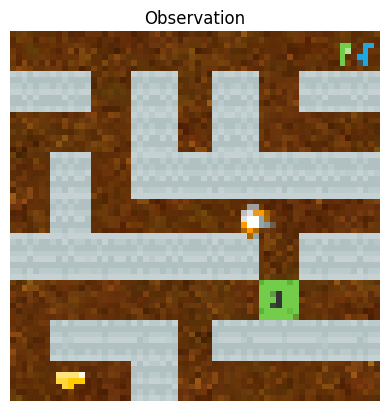

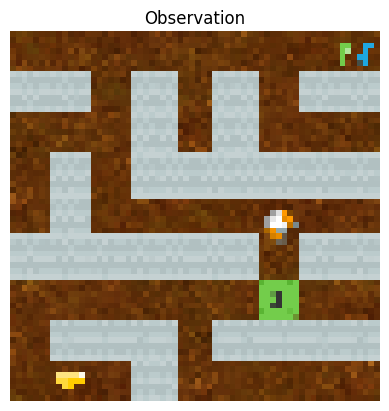

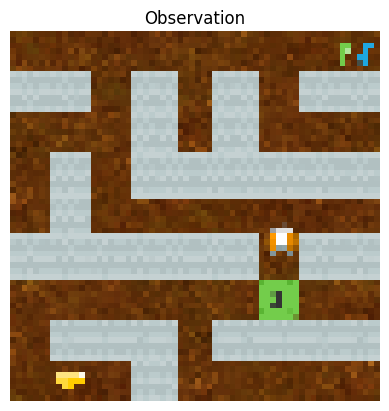

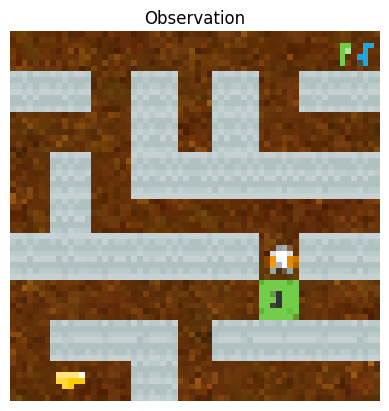

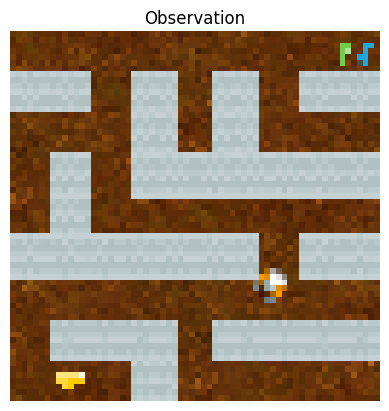

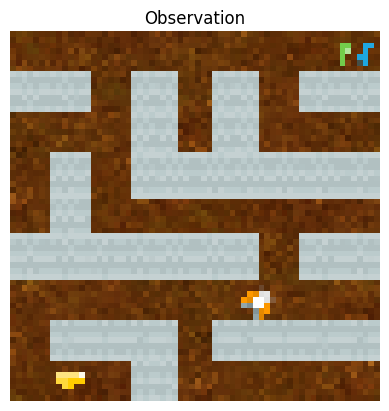

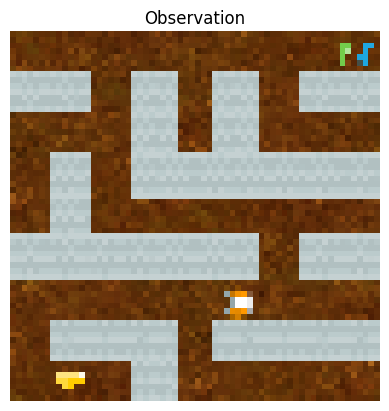

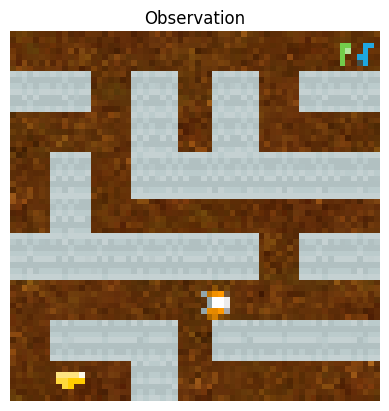

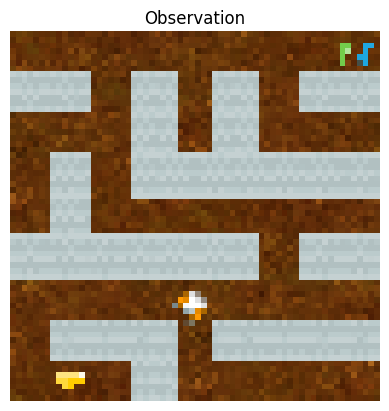

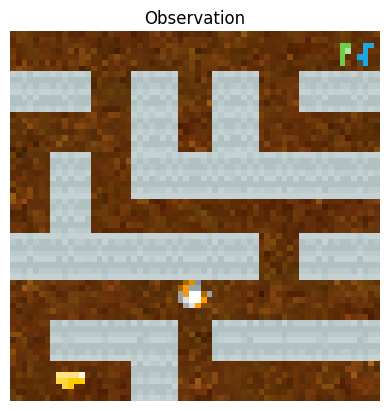

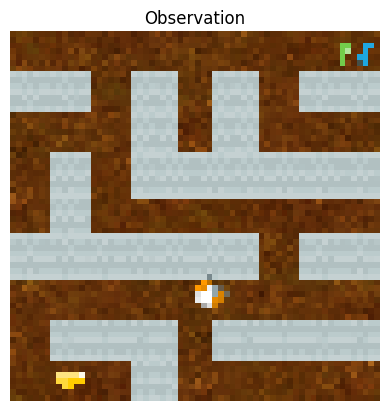

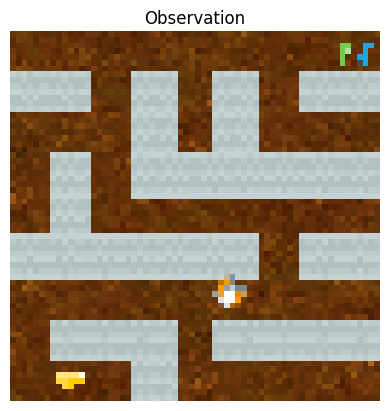

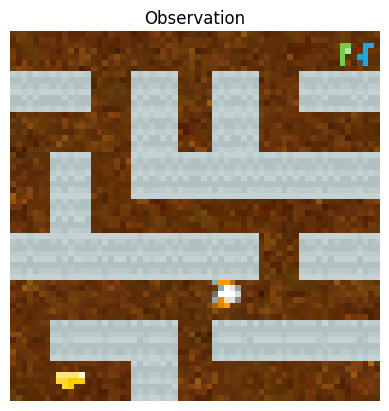

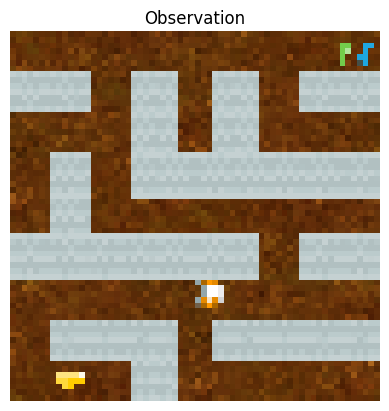

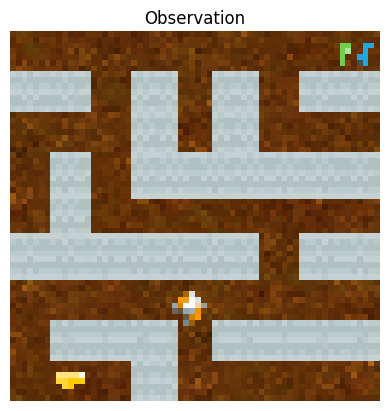

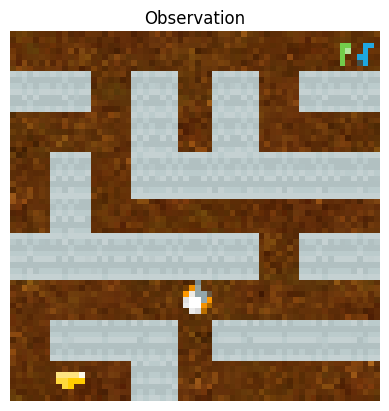

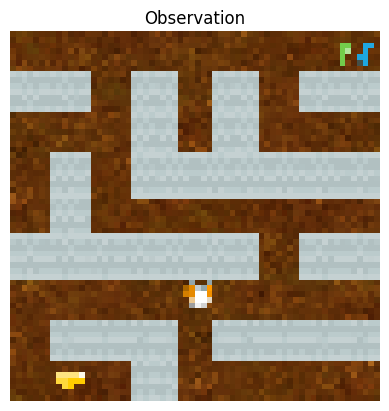

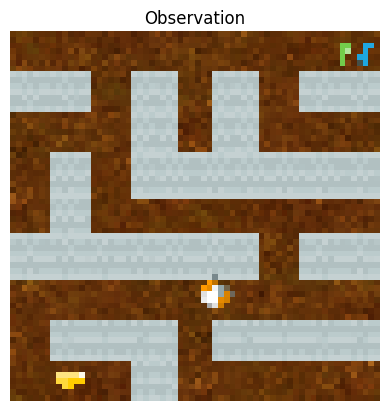

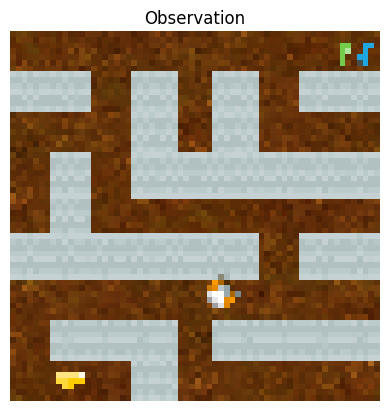

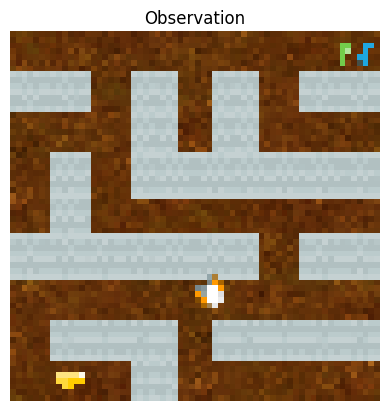

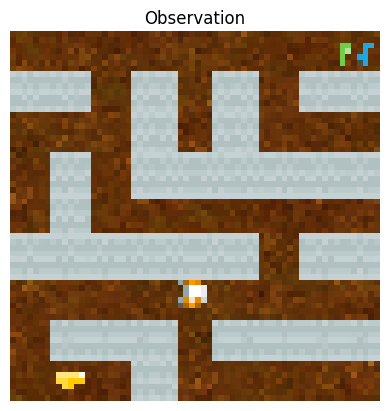

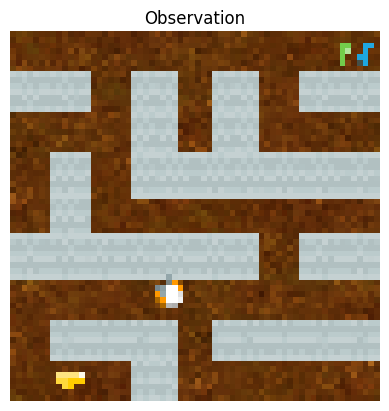

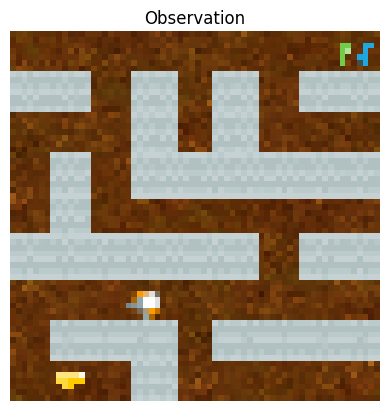

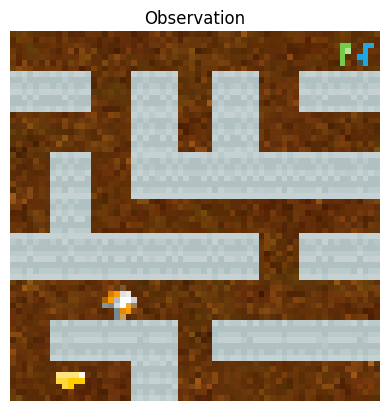

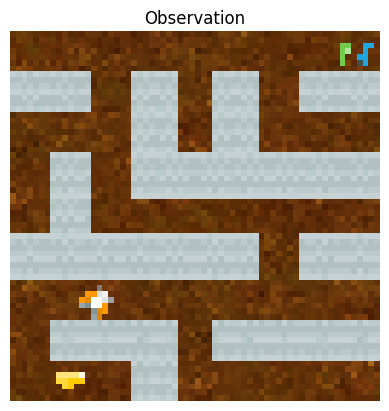

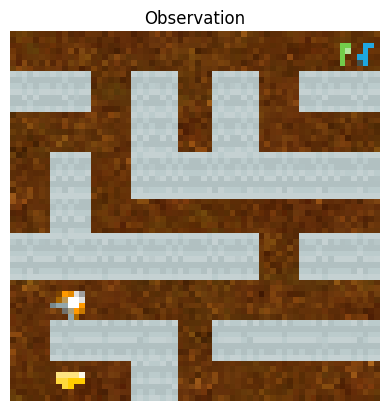

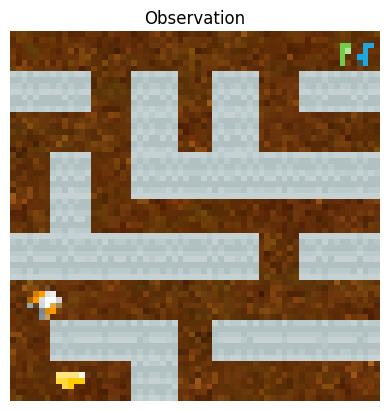

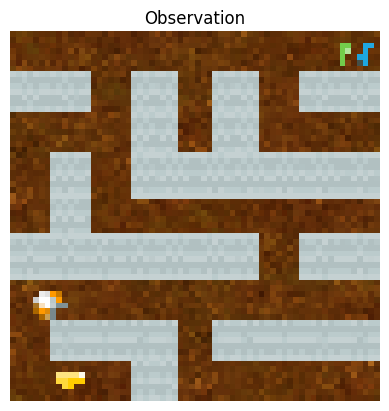

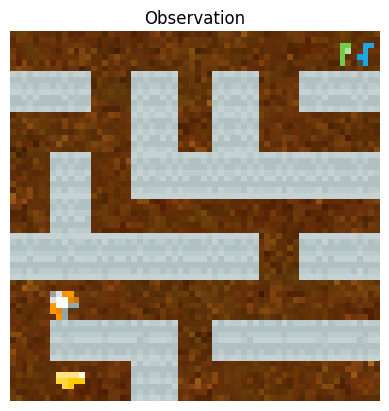

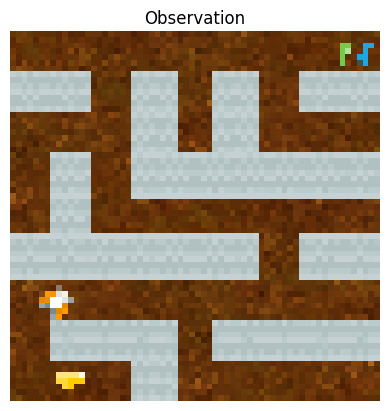

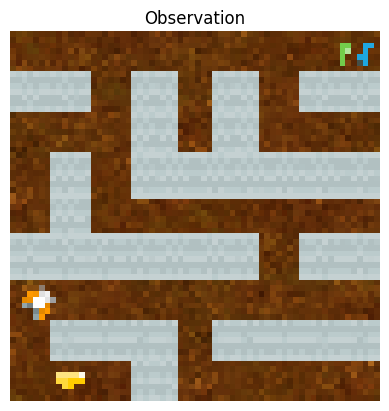

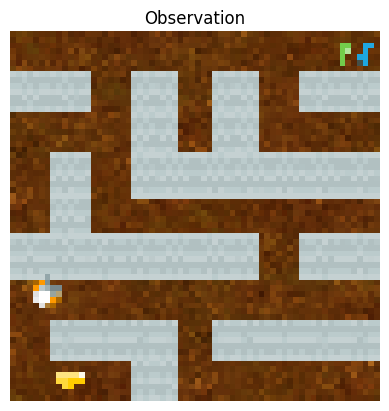

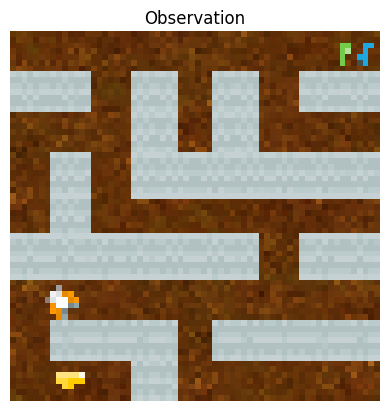

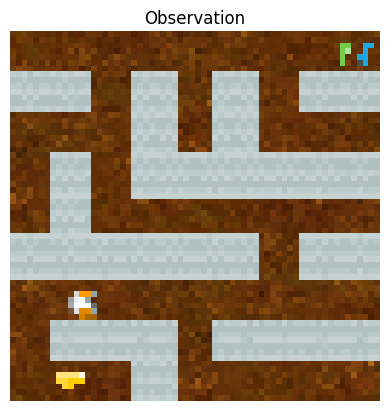

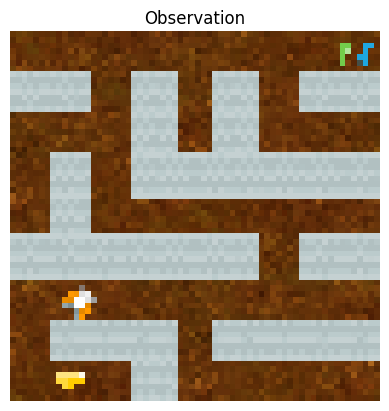

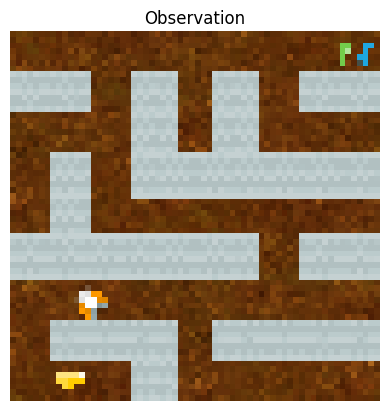

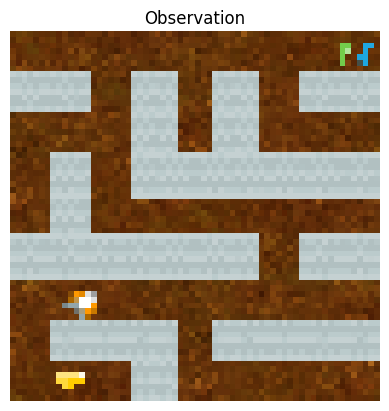

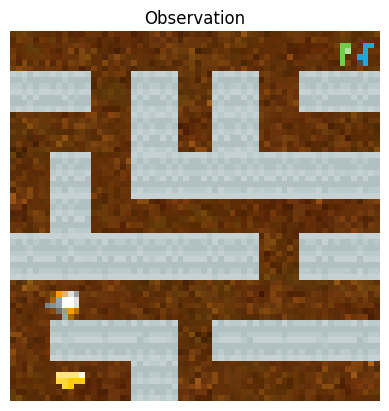

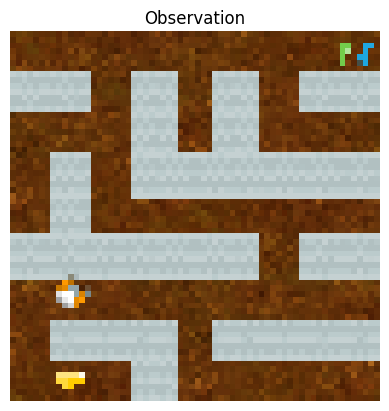

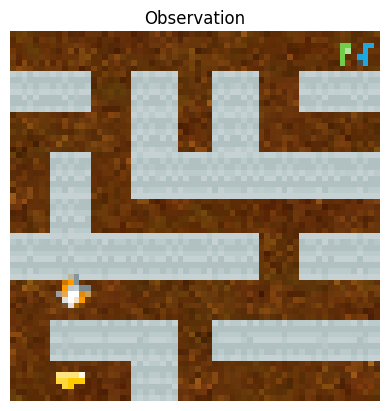

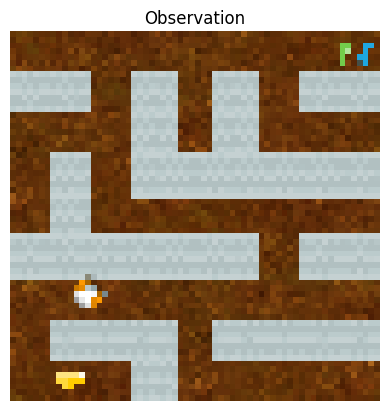

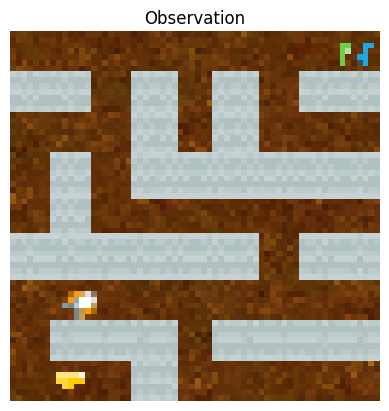

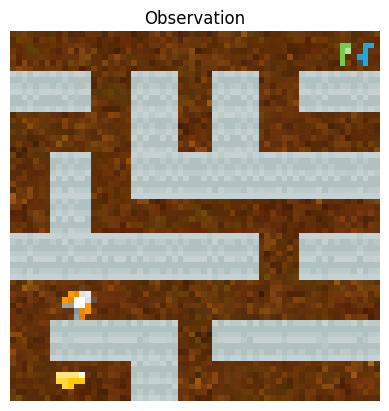

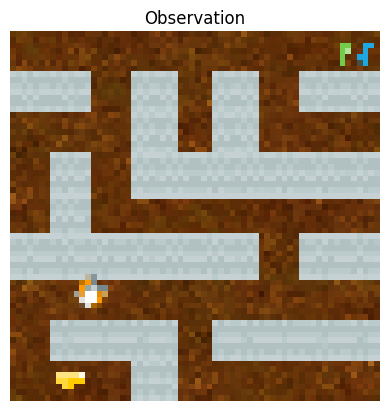

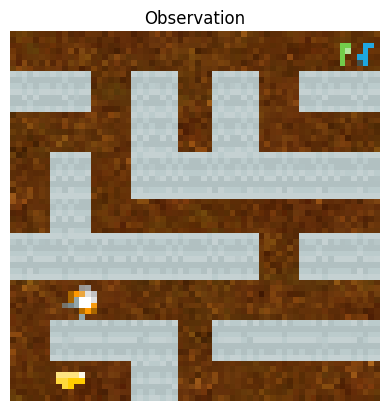

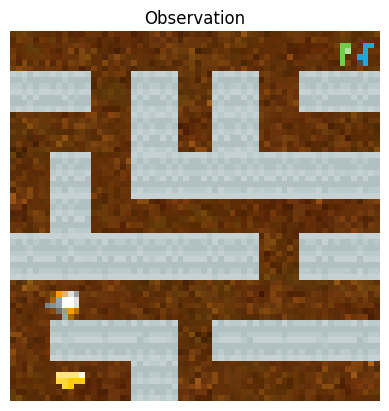

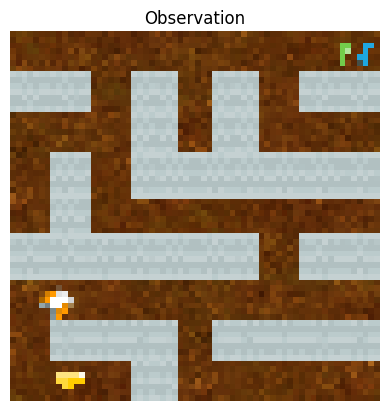

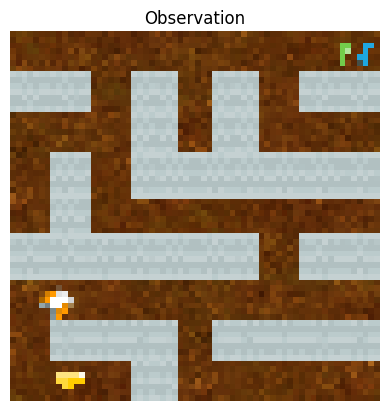

Present keys: []
Present locks: []


In [10]:
model_path = "../model_final.pt"
model = helpers.load_model(model_path=model_path)
layer_number = 14
start_level = random.randint(1, 10000)
save_gif = False
episode_timeout = 100
num_levels=1
modification_value = -3.5


venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
state = heist.state_from_venv(venv, 0)
unchanged_obs = venv.reset()
state_values = state.state_vals

for ents in state_values["ents"]:
    if ents["image_type"].val== 9:
        gem_x = ents["x"].val 
        gem_y = ents["y"].val 

state.remove_gem()

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs = venv.reset()

state = heist.state_from_venv(venv, 0)

state.set_gem_position(gem_y-.5,gem_x-.5)

state_bytes = state.state_bytes

if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
# Load model and calculate steering vector

model = helpers.load_model(model_path=model_path)
layer_names = helpers.get_model_layer_names(model)
steering_layer_unchanged = ordered_layer_names[layer_number]
steering_layer = helpers.rename_path(steering_layer_unchanged)

model_activations = helpers.ModelActivations(model)
model_activations.clear_hooks()
output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
model_activations.clear_hooks()
output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), layer_names)

steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

present_keys, present_locks, total_reward = run_episode_with_steering_and_check_all_target_acquisition(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_locks.gif',
        save_gif=True, episode_timeout=episode_timeout
    )
print("Present keys:", present_keys)
print("Present locks:", present_locks)

In [18]:
import random
from helpers import load_model, ModelActivations, observation_to_rgb, get_model_layer_names, rename_path
import heist

# Constants and Initial Setup
model_path = "../model_final.pt"
layer_number = 14
episode_timeout = 100
num_levels = 1
modification_value = -3.5
num_trials = 50
empty_count = 0  # Counter for how often both lists are empty

# Load the model outside the loop, assuming model doesn't change
model = helpers.load_model(model_path=model_path)
layer_names = helpers.get_model_layer_names(model)
steering_layer_unchanged = ordered_layer_names[layer_number]
steering_layer = helpers.rename_path(steering_layer_unchanged)

for _ in range(num_trials):
    start_level = random.randint(1, 10000)
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
    state = heist.state_from_venv(venv, 0)
    unchanged_obs = venv.reset()
    state_values = state.state_vals

    # Assuming the existence and structure of gems are consistent
    for ents in state_values["ents"]:
        if ents["image_type"].val == 9:
            gem_x = ents["x"].val
            gem_y = ents["y"].val

    state.remove_gem()
    state_bytes = state.state_bytes
    if state_bytes:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state.set_gem_position(gem_y - 0.5, gem_x - 0.5)
    state_bytes = state.state_bytes

    if state_bytes:
        venv.env.callmethod("set_state", [state_bytes])

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), layer_names)
    
    steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

    present_keys, present_locks,total_reward = run_episode_with_steering_and_check_all_target_acquisition(
        venv, model, steering_vector, steering_layer=layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_locks.gif',
        save_gif=False, episode_timeout=episode_timeout
    )

    # Check if both lists are empty and increment the counter
    if not present_keys and not present_locks and total_reward == 0:
        empty_count += 1

print(f"Both keys and locks were empty in {empty_count} out of {num_trials} trials.")


KeyboardInterrupt: 

Both keys and locks were empty in 1 out of 40 trials for modification value -1.
Both keys and locks were empty in 8 out of 40 trials for modification value -2.
Both keys and locks were empty in 13 out of 40 trials for modification value -3.
Both keys and locks were empty in 9 out of 40 trials for modification value -4.
Both keys and locks were empty in 18 out of 40 trials for modification value -5.


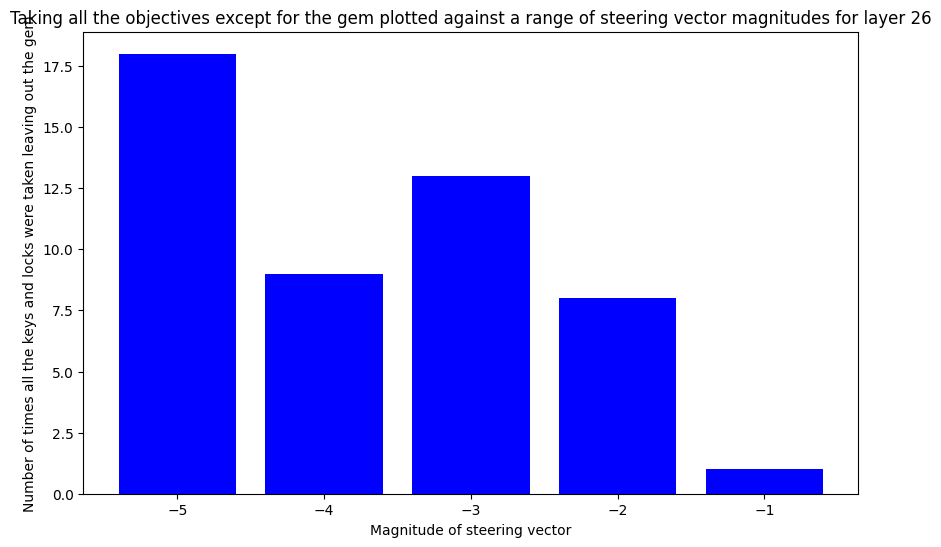

In [22]:
import random
import matplotlib.pyplot as plt
from helpers import load_model, ModelActivations, observation_to_rgb, get_model_layer_names
import heist

# Constants and Initial Setup
model_path = "../model_final.pt"
layer_number = 26
episode_timeout = 100
num_levels = 1
num_trials = 40

# Modification values range
modification_values = range(-1, -6, -1)  # from -1 to -5 inclusive

# Load the model outside the loop, assuming model doesn't change
model = helpers.load_model(model_path=model_path)
layer_names = helpers.get_model_layer_names(model)
steering_layer_unchanged = ordered_layer_names[layer_number]
steering_layer = helpers.rename_path(steering_layer_unchanged)


# Dictionary to store empty counts for each modification value
empty_counts = {mod_val: 0 for mod_val in modification_values}

for modification_value in modification_values:
    for _ in range(num_trials):
        start_level = random.randint(1, 10000)
        venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
        state = heist.state_from_venv(venv, 0)
        unchanged_obs = venv.reset()
        state_values = state.state_vals
    
        # Assuming the existence and structure of gems are consistent
        for ents in state_values["ents"]:
            if ents["image_type"].val == 9:
                gem_x = ents["x"].val
                gem_y = ents["y"].val
    
        state.remove_gem()
        state_bytes = state.state_bytes
        if state_bytes:
            venv.env.callmethod("set_state", [state_bytes])
            modified_obs = venv.reset()
    
        state.set_gem_position(gem_y - 0.5, gem_x - 0.5)
        state_bytes = state.state_bytes
    
        if state_bytes:
            venv.env.callmethod("set_state", [state_bytes])
    
        model_activations = helpers.ModelActivations(model)
        model_activations.clear_hooks()
        output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
        model_activations.clear_hooks()
        output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), layer_names)
        
        steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]
    
        present_keys, present_locks,total_reward = run_episode_with_steering_and_check_all_target_acquisition(
            venv, model, steering_vector, steering_layer=layer_names[layer_number],
            modification_value=modification_value, filepath=f'episode_steering_locks.gif',
            save_gif=False, episode_timeout=episode_timeout
        )

        # Check if both lists are empty and increment the counter
        if not present_keys and not present_locks and total_reward == 0:
            empty_counts[modification_value] += 1

    print(f"Both keys and locks were empty in {empty_counts[modification_value]} out of {num_trials} trials for modification value {modification_value}.")

# Plotting the results
mod_values = list(empty_counts.keys())
empty_results = list(empty_counts.values())
plt.figure(figsize=(10, 6))
plt.bar(mod_values, empty_results, color='blue')
plt.xlabel('Magnitude of steering vector')
plt.ylabel('Number of times all the keys and locks were taken leaving out the gem')
plt.title(f'Taking all the objectives except for the gem plotted against a range of steering vector magnitudes for layer {layer_number}')

plt.xticks(mod_values)
plt.show()


Both keys and locks were empty in 2 out of 40 trials for modification value -1.
Both keys and locks were empty in 4 out of 40 trials for modification value -2.
Both keys and locks were empty in 11 out of 40 trials for modification value -3.
Both keys and locks were empty in 8 out of 40 trials for modification value -4.
Both keys and locks were empty in 12 out of 40 trials for modification value -5.
Both keys and locks were empty in 12 out of 40 trials for modification value -6.
Both keys and locks were empty in 16 out of 40 trials for modification value -7.


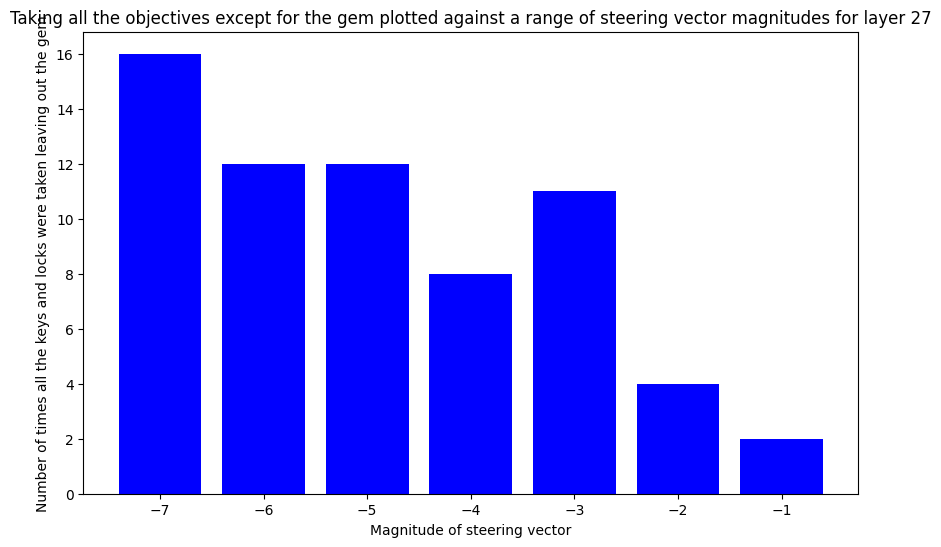

In [24]:
import random
import matplotlib.pyplot as plt
from helpers import load_model, ModelActivations, observation_to_rgb, get_model_layer_names
import heist

# Constants and Initial Setup
model_path = "../model_final.pt"
layer_number = 27
episode_timeout = 100
num_levels = 1
num_trials = 40

# Modification values range
modification_values = range(-1, -8, -1)  # from -1 to -5 inclusive

# Load the model outside the loop, assuming model doesn't change
model = helpers.load_model(model_path=model_path)
layer_names = helpers.get_model_layer_names(model)
steering_layer_unchanged = ordered_layer_names[layer_number]
steering_layer = helpers.rename_path(steering_layer_unchanged)


# Dictionary to store empty counts for each modification value
empty_counts = {mod_val: 0 for mod_val in modification_values}

for modification_value in modification_values:
    for _ in range(num_trials):
        start_level = random.randint(1, 10000)
        venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
        state = heist.state_from_venv(venv, 0)
        unchanged_obs = venv.reset()
        state_values = state.state_vals
    
        # Assuming the existence and structure of gems are consistent
        for ents in state_values["ents"]:
            if ents["image_type"].val == 9:
                gem_x = ents["x"].val
                gem_y = ents["y"].val
    
        state.remove_gem()
        state_bytes = state.state_bytes
        if state_bytes:
            venv.env.callmethod("set_state", [state_bytes])
            modified_obs = venv.reset()
    
        state.set_gem_position(gem_y - 0.5, gem_x - 0.5)
        state_bytes = state.state_bytes
    
        if state_bytes:
            venv.env.callmethod("set_state", [state_bytes])
    
        model_activations = helpers.ModelActivations(model)
        model_activations.clear_hooks()
        output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
        model_activations.clear_hooks()
        output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), layer_names)
        
        steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]
    
        present_keys, present_locks,total_reward = run_episode_with_steering_and_check_all_target_acquisition(
            venv, model, steering_vector, steering_layer=layer_names[layer_number],
            modification_value=modification_value, filepath=f'episode_steering_locks.gif',
            save_gif=False, episode_timeout=episode_timeout
        )

        # Check if both lists are empty and increment the counter
        if not present_keys and not present_locks and total_reward == 0:
            empty_counts[modification_value] += 1

    print(f"Both keys and locks were empty in {empty_counts[modification_value]} out of {num_trials} trials for modification value {modification_value}.")

# Plotting the results
mod_values = list(empty_counts.keys())
empty_results = list(empty_counts.values())
plt.figure(figsize=(10, 6))
plt.bar(mod_values, empty_results, color='blue')
plt.xlabel('Magnitude of steering vector')
plt.ylabel('Number of times all the keys and locks were taken leaving out the gem')
plt.title(f'Taking all the objectives except for the gem plotted against a range of steering vector magnitudes for layer {layer_number}')

plt.xticks(mod_values)
plt.show()


In [26]:
print(model)

ImpalaCNN(
  (conv_seqs): ModuleList(
    (0): ConvSequence(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool2d): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (res_block0): ResidualBlock(
        (conv0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (res_block1): ResidualBlock(
        (conv0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ConvSequence(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool2d): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (res_block0): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1): Conv2d(3

In [28]:
def check_model_components(model):
    # Check if 'conv_seqs' is an instance of ModuleList
    assert isinstance(model.conv_seqs, torch.nn.ModuleList), "conv_seqs should be an instance of torch.nn.ModuleList"

    # Loop through each ConvSequence in conv_seqs
    for i, conv_seq in enumerate(model.conv_seqs):
        # Check convolution layer
        assert isinstance(conv_seq.conv, torch.nn.Conv2d), f"conv in ConvSequence {i} should be an instance of torch.nn.Conv2d"
        # Check max pooling layer
        assert isinstance(conv_seq.max_pool2d, torch.nn.MaxPool2d), f"max_pool2d in ConvSequence {i} should be an instance of torch.nn.MaxPool2d"
        # Check each residual block
        for j, res_block in enumerate([conv_seq.res_block0, conv_seq.res_block1]):
            # Check both convolutional layers within the residual block
            assert isinstance(res_block.conv0, torch.nn.Conv2d), f"conv0 in ResidualBlock {j} of ConvSequence {i} should be an instance of torch.nn.Conv2d"
            assert isinstance(res_block.conv1, torch.nn.Conv2d), f"conv1 in ResidualBlock {j} of ConvSequence {i} should be an instance of torch.nn.Conv2d"

    # Check other components of ImpalaCNN
    assert isinstance(model.hidden_fc, torch.nn.Linear), "hidden_fc should be an instance of torch.nn.Linear"
    assert isinstance(model.logits_fc, torch.nn.Linear), "logits_fc should be an instance of torch.nn.Linear"
    assert isinstance(model.value_fc, torch.nn.Linear), "value_fc should be an instance of torch.nn.Linear"

    print("All components are properly initiated")

In [29]:
check_model_components(model)

All components are properly initiated
